# ACS2ER in Maze
This notebook presents how to integrate ACS2ER algorithm with maze environment (using OpenAI Gym interface).

Begin with attaching required dependencies. Because most of the work is by now done locally no PIP modules are used (just pure OS paths)

In [8]:
# General
from __future__ import unicode_literals

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# To avoid Type3 fonts in generated pdf file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Logger
import logging
logging.basicConfig(level=logging.INFO)


# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.agents.acs2er import ACS2ER, Configuration, ClassifiersList

# Load environments
import gym
import gym_maze
import gym_woods

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment - Maze
We are going to look at provided mazes. Their names starts with "_Maze..._" or "_Woods..._" so see what is possible to load:

In [10]:
# Custom function for obtaining available environments
filter_envs = lambda env: env.id.startswith("Maze") or env.id.startswith("Woods")

all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    print("Maze ID: [{}], non-deterministic: [{}]".format(env.id, env.nondeterministic, ))

Maze ID: [MazeF1-v0], non-deterministic: [False]
Maze ID: [MazeF2-v0], non-deterministic: [False]
Maze ID: [MazeF3-v0], non-deterministic: [False]
Maze ID: [MazeF4-v0], non-deterministic: [True]
Maze ID: [Maze4-v0], non-deterministic: [False]
Maze ID: [Maze5-v0], non-deterministic: [False]
Maze ID: [Maze6-v0], non-deterministic: [True]
Maze ID: [MazeT2-v0], non-deterministic: [False]
Maze ID: [MazeT3-v0], non-deterministic: [False]
Maze ID: [MazeT4-v0], non-deterministic: [True]
Maze ID: [Maze228-v0], non-deterministic: [True]
Maze ID: [Maze252-v0], non-deterministic: [True]
Maze ID: [Maze288-v0], non-deterministic: [True]
Maze ID: [Maze324-v0], non-deterministic: [True]
Maze ID: [Woods1-v0], non-deterministic: [False]
Maze ID: [Woods2-v0], non-deterministic: [False]
Maze ID: [Woods14-v0], non-deterministic: [False]
Maze ID: [Woods100-v0], non-deterministic: [True]


Let's see how it looks in action. First we are going to initialize new environment using `gym.make()` instruction from OpenAI Gym.

In [11]:
#MAZE = "Woods14-v0"
MAZE = "MazeT2-v0"

# Initialize environment
maze = gym.make(MAZE)

# Reset it, by putting an agent into random position
situation = maze.reset()

# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■
■ $ □ □ □ □ ■
■ ■ ■ □ ■ ■ ■
■ ■ ■ □ ■ ■ ■
■ ■ ■ A ■ ■ ■
■ ■ ■ ■ ■ ■ ■


## Agent - ACS2ER
First provide a helper method for calculating obtained knowledge

In [12]:
def _maze_knowledge(population, environment) -> float:
    transitions = environment.env.get_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:

        p0 = environment.env.maze.perception(start)
        p1 = environment.env.maze.perception(end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions) * 100.0

In [13]:
from lcs.metrics import population_metrics

def _maze_metrics(agent, env):
    pop = agent.population
    metrics = {
        'knowledge': _maze_knowledge(pop, env)
    }

    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

### Exploration phase

In [14]:
# The size of ER replay memory buffer
ER_BUFFER_SIZE=1000

# The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
ER_BUFFER_MIN_SAMPLES=100

# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER=3


# Define agent's configuration
cfg = Configuration(classifier_length=8,
                    number_of_possible_actions=8,
                    epsilon=0.5,
                    do_ga=True,
                    do_pee=False,
                    metrics_trial_frequency=1,
                    er_buffer_size=ER_BUFFER_SIZE,
                    er_min_samples=ER_BUFFER_MIN_SAMPLES,
                    er_samples_number=ER_SAMPLES_NUMBER,
                    user_metrics_collector_fcn=_maze_metrics)

# Define agent
agent = ACS2ER(cfg)



In [15]:
%%time
metrics_explore = agent.explore(maze, 100)

INFO:lcs.agents.Agent:{'trial': 10, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.2949453999999605, 'knowledge': 0.0, 'population': 151, 'numerosity': 187, 'reliable': 63}
INFO:lcs.agents.Agent:{'trial': 20, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.4325368999999455, 'knowledge': 0.0, 'population': 225, 'numerosity': 360, 'reliable': 115}
INFO:lcs.agents.Agent:{'trial': 30, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.4515890999999783, 'knowledge': 5.88235294117647, 'population': 241, 'numerosity': 460, 'reliable': 160}
INFO:lcs.agents.Agent:{'trial': 40, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.45091930000000957, 'knowledge': 5.88235294117647, 'population': 235, 'numerosity': 505, 'reliable': 168}
INFO:lcs.agents.Agent:{'trial': 50, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.38688439999998536, 'knowledge': 0.0, 'population': 206, 'numerosity': 506, 'reliable': 161}
INFO:lcs.agents.Agent:{'trial': 60, 'steps_in_trial': 21, 'reward': 1000, 'perf_time': 0

Wall time: 26 s


We can take a sneak peek into a created list of classifiers. Let's have a look at top 10:

In [18]:

# print few classifiers
population = agent.population
population.sort(key=lambda cl: -cl.fitness)

for cl in population[:10]:
    print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f}".format(cl, cl.q, cl.r, cl.ir))

###0#### 6 ########         (empty)               q: 1.0   r: 1.088e+03 ir: 999.5  f: 1.087e+03 exp: 150 tga: 3616  talp: 3616  tav: 17.1   num: 17 	q: 1.00 	r: 1087.52 	ir: 999.54
######9# 6 ########         (empty)               q: 1.0   r: 1.088e+03 ir: 999.5  f: 1.087e+03 exp: 149 tga: 3616  talp: 3616  tav: 17.1   num: 2 	q: 1.00 	r: 1087.52 	ir: 999.54
###0##9# 6 ########         (empty)               q: 0.999 r: 1.088e+03 ir: 999.5  f: 1.087e+03 exp: 130 tga: 3616  talp: 3616  tav: 17.1   num: 1 	q: 1.00 	r: 1087.52 	ir: 999.54
#0##0#10 1 110#1001         (empty)               q: 1.0   r: 93.0   ir: 0.0    f: 93.0   exp: 226 tga: 3504  talp: 3595  tav: 24.7   num: 1 	q: 1.00 	r: 93.00 	ir: 0.00
001#0#10 1 110#1001         (empty)               q: 1.0   r: 93.0   ir: 0.0    f: 93.0   exp: 226 tga: 3504  talp: 3595  tav: 24.7   num: 1 	q: 1.00 	r: 93.00 	ir: 0.00
#01#0##0 1 110#1001         (empty)               q: 1.0   r: 93.0   ir: 0.0    f: 93.0   exp: 210 tga: 3504  talp: 359

### Exploitation

Now we can either reuse our previous agent or initialize it one more time passing the initial population of classifiers as *apriori* knowledge.

In [19]:
# Reinitialize agent using defined configuration and population
agent = ACS2ER(cfg, population)

In [20]:
%%time
metrics_exploit = agent.exploit(maze, 10)

INFO:lcs.agents.Agent:{'trial': 1, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.05842270000005101, 'knowledge': 5.88235294117647, 'population': 133, 'numerosity': 497, 'reliable': 113}
INFO:lcs.agents.Agent:{'trial': 2, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.06952730000000429, 'knowledge': 0.0, 'population': 133, 'numerosity': 497, 'reliable': 113}
INFO:lcs.agents.Agent:{'trial': 3, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.07233819999999014, 'knowledge': 0.0, 'population': 133, 'numerosity': 497, 'reliable': 113}
INFO:lcs.agents.Agent:{'trial': 4, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.06670339999993757, 'knowledge': 0.0, 'population': 133, 'numerosity': 497, 'reliable': 113}
INFO:lcs.agents.Agent:{'trial': 5, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.06645539999999528, 'knowledge': 0.0, 'population': 133, 'numerosity': 497, 'reliable': 113}
INFO:lcs.agents.Agent:{'trial': 6, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.08170490000009067

Wall time: 700 ms


## Experiments

In [22]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['steps'] = row['steps_in_trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['knowledge'] = row['knowledge']
        return row
    
    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.set_index('trial', inplace=True)
    
    return df

For various mazes visualize
- classifiers / reliable classifiers for steps
- optimal policy
- steps (exploration | exploitation)
- knowledge
- parameters setting

In [23]:
def find_best_classifier(population, situation):
    match_set = population.form_match_set(situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population):
    original = env.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population):
    ACTION_LOOKUP = { 
        0: u'↑', 1: u'↗', 2: u'→', 3: u'↘',
        4: u'↓', 5: u'↙', 6: u'←', 7: u'↖'
    }
    
    original = env.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action

## Plotting functions and settings

In [25]:
# Plot constants
TITLE_TEXT_SIZE=24
AXIS_TEXT_SIZE=18
LEGEND_TEXT_SIZE=16

In [26]:
def plot_policy(env, agent, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    max_x, max_y = env.env.maze.matrix.shape
    
    fitness_matrix = build_fitness_matrix(env, agent.population)
    action_matrix = build_action_matrix(env, agent.population)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto', extent=[0, max_x, max_y, 0])
    
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel('x', fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel('y', fontsize=AXIS_TEXT_SIZE)

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)

In [27]:
def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
        
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])

In [28]:
def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Steps", fontsize=AXIS_TEXT_SIZE)

In [29]:
def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')    
    
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)

In [30]:
def plot_performance(agent, maze, metrics_df, env_name):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'ACS2ER Performance in {env_name} environment', fontsize=32)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, agent, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)
    
    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)
    
    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)
    
    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)

# PLOT METRICS

In [34]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)

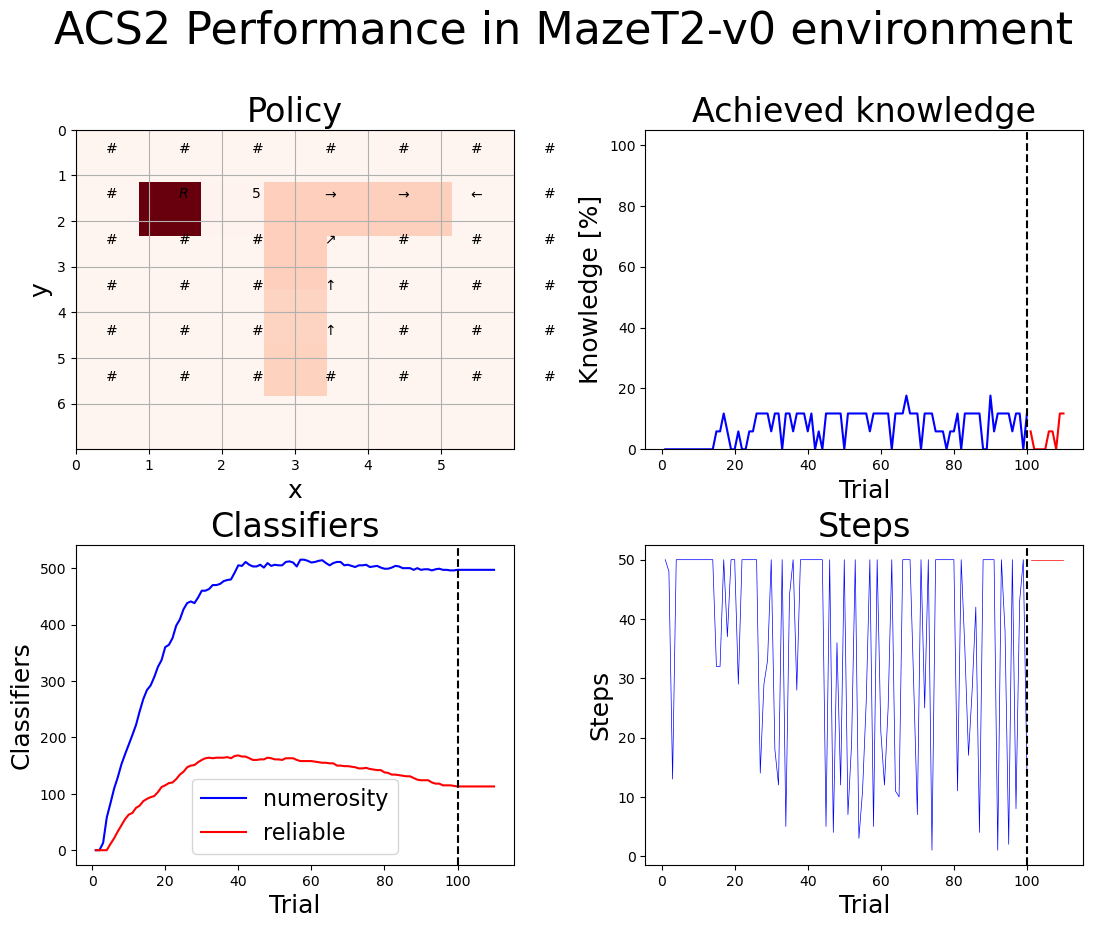

In [35]:
plot_performance(agent, maze, metrics_df, MAZE)